
# Importing

In [8]:
!pip uninstall python-louvain -y
!pip install python-louvain
# colab setting
!pip install GraphRicciCurvature
!pip install scikit-learn

# import sys
# sys.path.append("../")


import networkx as nx
import numpy as np
import math
import random

# matplotlib setting
%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci


# load python-louvain for modularity computation
!pip uninstall community -y
import community.community_louvain as community_louvain

# for ARI computation
from sklearn import preprocessing, metrics
import pandas as pd


zsh:1: command not found: pip


zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip


ModuleNotFoundError: No module named 'GraphRicciCurvature'

In [ ]:
!pip install cdlib
from cdlib import algorithms


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 14.7 MB/s eta 0:00:00
Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy', 'leidenalg', 'wurlitzer', 'infomap', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'leidenalg'}


In [ ]:
import GraphRicciCurvature
print(GraphRicciCurvature.__version__)
from urllib.request import urlopen
from GraphRicciCurvature.util import cut_graph_by_cutoff

0.5.3.1


# Helper Functions

In [ ]:
def draw_graph(G, clustering_label="block"):
    """
    A helper function to draw a nx graph with community.
    """
    complex_list = nx.get_node_attributes(G, clustering_label)

    le = preprocessing.LabelEncoder()
    node_color = le.fit_transform(list(complex_list.values()))


    nx.draw_spring(G, nodelist=G.nodes(),
                   node_color=node_color,
                   cmap=plt.cm.rainbow,
                   alpha=0.8)



def show_results(G, curvature="ricciCurvature"):
    """
    A helper function to show summary of curvature in a graph

    # parameters
     - G : networkx graph
    # returns
     - plot of summaries
    """
    # Print the first five results
    print("Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2][curvature]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, curvature).values()
    plt.hist(ricci_curvtures,bins=20)
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20)
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights")

    plt.tight_layout()


def ARI(G, clustering, clustering_label="block"):
    """
    Computer the Adjust Rand Index (clustering accuracy) of "clustering" with "clustering_label" as ground truth.

    Parameters
    ----------
    G : NetworkX graph
        A given NetworkX graph with node attribute "clustering_label" as ground truth.
    clustering : dict or list or list of set
        Predicted community clustering.
    clustering_label : str
        Node attribute name for ground truth.

    Returns
    -------
    ari : float
        Adjust Rand Index for predicted community.
    """

    complex_list = nx.get_node_attributes(G, clustering_label)

    le = preprocessing.LabelEncoder()
    y_true = le.fit_transform(list(complex_list.values()))

    if isinstance(clustering, dict):
        # python-louvain partition format
        y_pred = np.array([clustering[v] for v in complex_list.keys()])
    elif isinstance(clustering[0], set):
        # networkx partition format
        predict_dict = {c: idx for idx, comp in enumerate(clustering) for c in comp}
        y_pred = np.array([predict_dict[v] for v in complex_list.keys()])
    elif isinstance(clustering, list):
        # sklearn partition format
        y_pred = clustering
    else:
        return -1

    return metrics.adjusted_rand_score(y_true, y_pred)


def my_surgery(G_origin: nx.Graph(), weight="weight", cut = 0):
    """

    Performs a graph "surgery" by removing edges with a weight above a specified threshold,
    then evaluates the resulting graph structure.

    Parameters
    ----------
    G_origin : nx.Graph
        The original graph where edges will be evaluated and potentially removed based on the
        specified weight attribute.
    weight : str, optional
        The name of the edge attribute to use as the criterion for removal. This attribute is often
        used to represent Ricci flow metrics or other forms of edge significance. Default is "weight".
    cut : float, optional
        The threshold value above which edges are removed. If not specified or set to 0, a default
        heuristic is used to determine a cutoff point based on the distribution of the weight values
        across all edges.

    Returns
    -------
    tuple
        A tuple containing several metrics evaluating the graph post-surgery:
        - The number of edges removed.
        - The number of nodes remaining in the graph.
        - The number of edges remaining in the graph.
        - The modularity of the graph, assessing the quality of division into communities.
        - The Adjusted Rand Index (ARI) based on the detected communities within the graph.
        - The modified graph (`nx.Graph`) after the removal of selected edges.
    """
    G = G_origin.copy()
    w = nx.get_edge_attributes(G, weight)

    assert cut >= 0, "Cut value should be greater than 0."
    if not cut:
        cut = (max(w.values()) - 1.0) * 0.6 + 1.0  # Guess a cut point as default

    to_cut = []
    for n1, n2 in G.edges():
        if G[n1][n2][weight] > cut:
            to_cut.append((n1, n2))
    G.remove_edges_from(to_cut)
    cc = list(nx.connected_components(G))


    return len(to_cut),G.number_of_nodes(), G.number_of_edges(), nx.algorithms.community.quality.modularity(G, cc), ARI(G, cc), G

In [ ]:
def check_accuracy(G_origin, weight="weight", clustering_label="block", plot_cut=True):
    """To check the clustering quality while cut the edges with weight using different threshold

    Parameters
    ----------
    G_origin : NetworkX graph
        A graph with ``weight`` as Ricci flow metric to cut.
    weight: float
        The edge weight used as Ricci flow metric. (Default value = "weight")
    clustering_label : str
        Node attribute name for ground truth.
    plot_cut: bool
        To plot the good guessed cut or not.

    """
    G = G_origin.copy()
    modularity, ari = [], []
    maxw = max(nx.get_edge_attributes(G, weight).values())
    cutoff_range = np.arange(maxw, 1, -0.025)

    for cutoff in cutoff_range:
        edge_trim_list = []
        for n1, n2 in G.edges():
            if G[n1][n2][weight] > cutoff:
                edge_trim_list.append((n1, n2))
        G.remove_edges_from(edge_trim_list)

        # Get connected component after cut as clustering
        clustering = {c: idx for idx, comp in enumerate(nx.connected_components(G)) for c in comp}

        # Compute modularity and ari
        links = G.size(weight=weight)
        if links > 0:
          modularity.append(community_louvain.modularity(clustering, G, weight))
        ari.append(ARI(G, clustering, clustering_label=clustering_label))

    plt.xlim(maxw, 0)
    plt.xlabel("Edge weight cutoff")
    plt.plot(cutoff_range, modularity, alpha=0.8)
    plt.plot(cutoff_range, ari, alpha=0.8)

    if plot_cut:
        good_cut = -1
        mod_last = modularity[-1]
        drop_threshold = 0.01  # at least drop this much to considered as a drop for good_cut

        # check drop from 1 -> maxw
        for i in range(len(modularity) - 1, 0, -1):
            mod_now = modularity[i]
            if mod_last > mod_now > 1e-4 and abs(mod_last - mod_now) / mod_last > drop_threshold:
                if good_cut != -1:
                    print("Other cut:%f, diff:%f, mod_now:%f, mod_last:%f, ari:%f" % (
                        cutoff_range[i + 1], mod_last - mod_now, mod_now, mod_last, ari[i + 1]))
                else:
                    good_cut = cutoff_range[i + 1]
                    print("*Good Cut:%f, diff:%f, mod_now:%f, mod_last:%f, ari:%f" % (
                        good_cut, mod_last - mod_now, mod_now, mod_last, ari[i + 1]))
            mod_last = mod_now

        plt.axvline(x=good_cut, color="red")
        plt.legend(['Modularity', 'Adjust Rand Index', 'Good cut'])
    else:
        plt.legend(['Modularity', 'Adjust Rand Index'])

# Missing Edges Helpers

In [ ]:
def block_model_with_edge_removal(block_sizes, prob_matrix, p = 0, method="uniform"):
    """
    Generates a block model graph and removes edges according to the specified method:
    uniformly, by degree, or based on inter-community probabilities.

    Parameters:
    - block_sizes : array-like, the size of each community.
    - prob_matrix : array-like, matrix of probabilities for edge creation between communities.
    - p : float, array-like, or matrix, specifying the probability or proportions of edges to remove.
      Interpreted based on the 'method' parameter.
    - method : str, method for edge removal ("uniform", "degree", or "weighted").

    Returns:
    - G : networkx graph, a graph with edges removed according to the specified method.
    """

    # Generate a stochastic block model graph
    G = nx.generators.community.stochastic_block_model(block_sizes, prob_matrix)

    # Assign 'block' attribute to each node based on its community
    club_attribute = {node: G.nodes[node]['block'] for node in G.nodes}
    nx.set_node_attributes(G, club_attribute, name='club')

    if method == "uniform" or method == "degree":
        edges_to_consider = list(G.edges(data=True))
    else:
        edges_to_consider = G.edges(data='block')

    if method == "uniform":
        for edge in edges_to_consider:
            if random.random() < p:
                G.remove_edge(edge[0], edge[1])

    elif method == "degree":
        for node in list(G.nodes()):
            adjacent_edges = list(G.edges(node))
            num_to_remove = int(len(adjacent_edges) * p)
            edges_to_remove = random.sample(adjacent_edges, num_to_remove)
            G.remove_edges_from(edges_to_remove)

    elif method == "weighted":
        if not isinstance(p, (list, np.ndarray)) or np.shape(p) != (len(block_sizes), len(block_sizes)):
            raise ValueError("For 'weighted' method, p must be a matrix matching the number of communities.")
        to_remove = set()
        for edge in edges_to_consider:
            source_block = G.nodes[edge[0]]['block']
            target_block = G.nodes[edge[1]]['block']
            removal_prob = p[source_block][target_block]

            if random.random() < removal_prob:
                to_remove.add(edge)
        for edge in to_remove:
            G.remove_edge(edge[0], edge[1])

    else:
        raise ValueError("Invalid method specified. Choose 'uniform', 'degree', or 'weighted'.")

    return G



def edges_between_communities(G):
    # Extract community information from each node
    communities = nx.get_node_attributes(G, 'block')
    unique_communities = set(communities.values())

    # Map communities to indices
    community_indices = {community: i for i, community in enumerate(unique_communities)}

    # Initialize the matrix with zeros
    matrix_size = len(unique_communities)
    community_matrix = np.zeros((matrix_size, matrix_size), dtype=int)

    # Iterate over each edge to count the edges between communities
    for u, v in G.edges():
        community_u = communities[u]
        community_v = communities[v]
        i = community_indices[community_u]
        j = community_indices[community_v]
        community_matrix[i][j] += 1
        if i != j:  # If the edge is not within the same community, increment the symmetric cell
            community_matrix[j][i] += 1

    return community_matrix

def ricci_simulation3(G, iterations = 15, alpha = 0, cut = 1.5, exp = 1):
  orf = OllivierRicci(G, alpha=alpha, base=1, exp_power=exp, proc=4, verbose="INFO")
  orf.compute_ricci_flow(iterations=iterations)
  G_rf = orf.G.copy()
  def detect_communities_and_modularity(G):
    # Perform community detection to optimize modularity
    partition = community_louvain.best_partition(G, weight='weight')

    # Calculate the modularity of the partition
    modularity = community_louvain.modularity(partition, G)

    return partition, modularity
  par, mod = detect_communities_and_modularity(G_rf)
  cc = list(nx.connected_components(G_rf))
  return len(cc), G_rf, ARI(G_rf, par), mod

def ricci_simulation2(G, iterations = 60, alpha = 0, cut = 1.5, exp = 1):
  orf = OllivierRicci(G, alpha=alpha, base=1, exp_power=exp, proc=4, verbose="ERROR")
  orf.compute_ricci_flow(iterations=iterations)
  G_rf = orf.G.copy()
  cc = GraphRicciCurvature.util.get_rf_metric_cutoff(G_rf, weight='weight', cutoff_step=0.025, drop_threshold=0.01)
  G_cut = cut_graph_by_cutoff(orf.G,cutoff=cc[0])
  partition = community_louvain.best_partition(G_cut, weight='weight')
  mod = community_louvain.modularity(partition, G_cut)
  return len(cc), G_rf, ARI(G_rf, partition), mod

def detect_communities_and_modularity(Gr, communities = 2, weight = 'weight'):
    G = Gr.copy()
    maxw = max(nx.get_edge_attributes(G, weight).values())
    cutoff_range = np.arange(maxw, 1, -0.025)
    for cutoff in cutoff_range:
        edge_trim_list = []
        for n1, n2 in G.edges():
            if G[n1][n2][weight] > cutoff:
                edge_trim_list.append((n1, n2))
        G.remove_edges_from(edge_trim_list)
        cc = nx.connected_components(G)
        # Get connected component after cut as clustering

        if nx.number_connected_components(G) >= communities:
          clustering = {c: idx for idx, comp in enumerate(cc) for c in comp}
          links = G.size(weight=weight)
          if links != 0:
            return nx.number_connected_components(G), clustering, community_louvain.modularity(clustering, G, weight), cutoff
          else:
            return nx.number_connected_components(G), clustering, -1, cutoff
    cc = nx.connected_components(G)
    clustering = {c: idx for idx, comp in enumerate(cc) for c in comp}
    return 1, clustering, community_louvain.modularity(clustering, Gr, weight), maxw

def ricci_simulation(G, iterations = 60, alpha = 0, exp = 1, delta = 0.00001,
                      communities = 2, detection = "manual"):
  orf = OllivierRicci(G, alpha=alpha, base=1, exp_power=exp, proc=4)
  orf.compute_ricci_flow(iterations=iterations, delta = delta)
  G_rf = orf.G.copy()
  numcom, par, mod, cutoff = detect_communities_and_modularity(G_rf, communities = communities)
  return numcom, G_rf, ARI(G_rf, par), mod, cutoff

# Testing


In [ ]:
block_sizes = [100, 100]
p_inter, p_intra = 0.125, 0.5
prob_matrix = [
    [p_intra, p_inter],
    [p_inter, p_intra]
]
G = block_model_with_edge_removal(block_sizes,
                                          prob_matrix=prob_matrix,
                                          p = 0.97,
                                          method = 'degree')

num_components, ricci_model, r_ari, r_mod, cutoff = ricci_simulation(G)


In [ ]:
num_components, r_ari, r_mod, cutoff

(1, 1.0, 0.0, 1.0)

Graph, first 5 edges: 
Ricci curvature of edge (49,2) is 0.000000


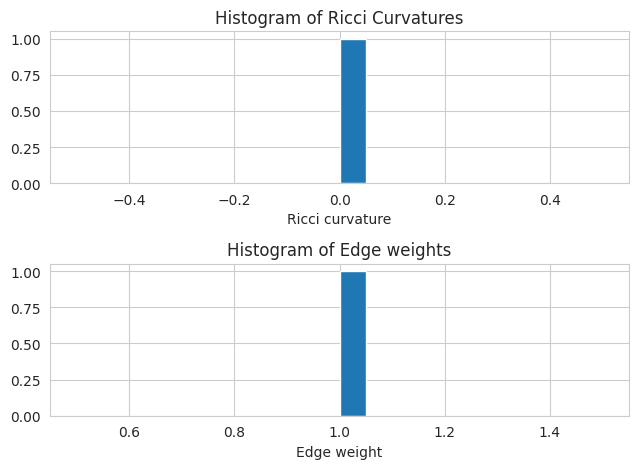

In [ ]:
G_rf = ricci_model.copy()
show_results(G_rf)

IndexError: list index out of range

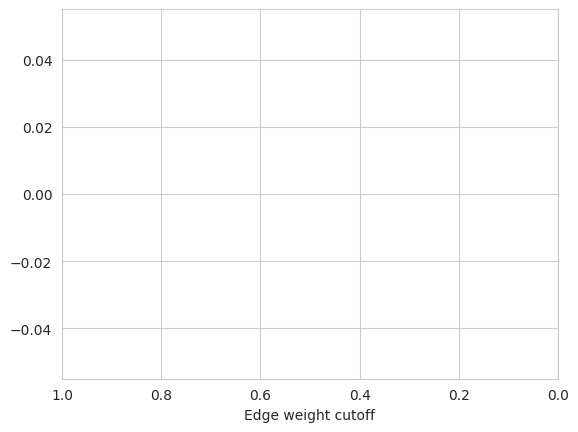

In [ ]:
check_accuracy(G_rf,clustering_label="block")

In [ ]:
G_cut = cut_graph_by_cutoff(G_rf,cutoff=cutoff)

In [ ]:
draw_graph(G_cut)

In [ ]:
clustering = {c: idx for idx, comp in enumerate(nx.connected_components(G_cut)) for c in comp}
clustering2 = {idx:c for idx, comp in enumerate(nx.connected_components(G_cut)) for c in comp}

community_louvain.modularity(clustering, G_cut)

# Spectral Helpers

In [ ]:
from sklearn.cluster import KMeans
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian
import numpy as np
from scipy.sparse.linalg import eigs
def spectral_analysis(G):
  adj_matrix = nx.adjacency_matrix(G)
  laplacian_matrix = laplacian(adj_matrix, normed=True)
  eigenvalues, eigenvectors = eigs(laplacian_matrix, k=2, which='SM', tol=0.01)
  eigenvectors = np.real(eigenvectors)
  kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(eigenvectors)
  labels = kmeans.labels_
  for i, node in enumerate(G.nodes()):
    G.nodes[node]['spectral_label'] = labels[i]
  predicted_labels = [G.nodes[node]['spectral_label'] for node in list(G.nodes)]
  return G, ARI(G, predicted_labels)


# Two-neighborhood Weighted Analysis

In [ ]:
# Definitions for initial problem

block_sizes = [100, 100]
p_inter, p_intra = 0.25, 0.5
prob_matrix = [
    [p_intra, p_inter],
    [p_inter, p_intra]
]

remove_prob_matrix = [
    [0.8, 0.7],
    [0.7, 0.8]
]

model = block_model_with_edge_removal(block_sizes,
                                      prob_matrix=prob_matrix,
                                      p = remove_prob_matrix,
                                      method = "weighted")
edges_between_communities(model)

array([[516, 765],
       [765, 491]])

INFO:GraphRicciCurvature:Edge weight not detected in graph, use "weight" as default edge weight.
TRACE:GraphRicciCurvature:Number of nodes: 200
TRACE:GraphRicciCurvature:Number of edges: 1259
TRACE:GraphRicciCurvature:Start to compute all pair shortest path.
TRACE:GraphRicciCurvature:0.010403 secs for all pair by NetworKit.
INFO:GraphRicciCurvature:0.670370 secs for Ricci curvature computation.


Graph, first 5 edges: 
Ricci curvature of edge (0,1) is -0.198052
Ricci curvature of edge (0,14) is -0.089286
Ricci curvature of edge (0,16) is -0.027778
Ricci curvature of edge (0,47) is -0.159524
Ricci curvature of edge (0,55) is -0.216667


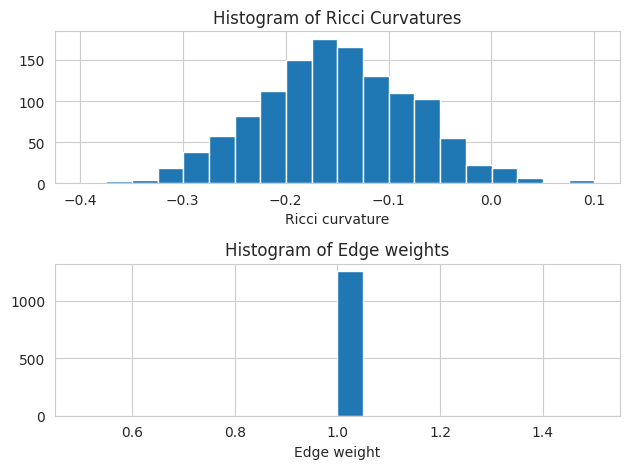

In [ ]:
initial = OllivierRicci(model, alpha=0.5, verbose="TRACE")
initial.compute_ricci_curvature()
curve_initial = initial.G.copy()  # save an intermediate result

show_results(curve_initial)

In [ ]:
weighted_data = dict()

In [ ]:
for i in [0.5, 0.7, 0.8, 0.85, 0.9, 0.95]:
  for j in [0.5, 0.7, 0.8, 0.85, 0.9, 0.95]:
    remove_prob_matrix = [
      [i, j],
      [j, i]]
    model = block_model_with_edge_removal(block_sizes,
                                      prob_matrix=prob_matrix,
                                      p = remove_prob_matrix,
                                      method = "weighted")
    num_cut, n, num_edges, mod, ari, G = ricci_simulation(model, iterations = 10, exp = 1)
    weighted_data[(i, j)] = (num_cut, n, num_edges, mod, ari, G)


INFO:GraphRicciCurvature:Edge weight not detected in graph, use "weight" as default edge weight.
INFO:GraphRicciCurvature:No ricciCurvature detected, compute original_RC...
INFO:GraphRicciCurvature:3.792951 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 0 === 
INFO:GraphRicciCurvature:3.392128 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 1 === 
INFO:GraphRicciCurvature:4.446498 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 2 === 
INFO:GraphRicciCurvature:3.803083 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 3 === 
INFO:GraphRicciCurvature:3.750967 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 4 === 
INFO:GraphRicciCurvature:4.938665 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 5 === 
INFO:GraphRicciCurvature:2.463937 secs for Ricc

In [ ]:
import pandas as pd
weighted_summary = pd.DataFrame(weighted_data).iloc[:5,]
weighted_summary['Names'] = ['Num_cut', 'Num nodes', 'num edges', 'Modularity', 'ARI']
weighted_summary.set_index('Names', inplace = True)
weighted_summary

0.50                                        0.70              \
            0.50  0.70  0.80  0.85      0.90      0.95  0.50  0.70  0.80   
Names                                                                      
Num_cut        0     4   408   399       224       141     0     0     0   
Num nodes    200   200   200   200       200       200   200   200   200   
num edges   3742  3189  2628  2457      2498      2485  2711  2300  2012   
Modularity  -0.0   0.0  -0.0   0.0  0.499998  0.499964   0.0  -0.0   0.0   
ARI          0.0   0.0   0.0   0.0       1.0       1.0   0.0   0.0   0.0   

                  ...  0.90                 0.95                           
            0.85  ...  0.80 0.85 0.90 0.95  0.50 0.70 0.80 0.85 0.90 0.95  
Names             ...                                                      
Num_cut       12  ...     0    0    0    1     0    0    0    0    2    8  
Num nodes    200  ...   200  200  200  200   200  200  200  199  198  195  
num edges   1855  ...  1054  845  765  645  1451  983  777  600  482  371  
Modularity   0.0  ...  -0.0 -0.0  0.0 -0.0   0.0  0.0  0.0  0.0  0.0 -0.0  
ARI          0.0  ...   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 36 columns]

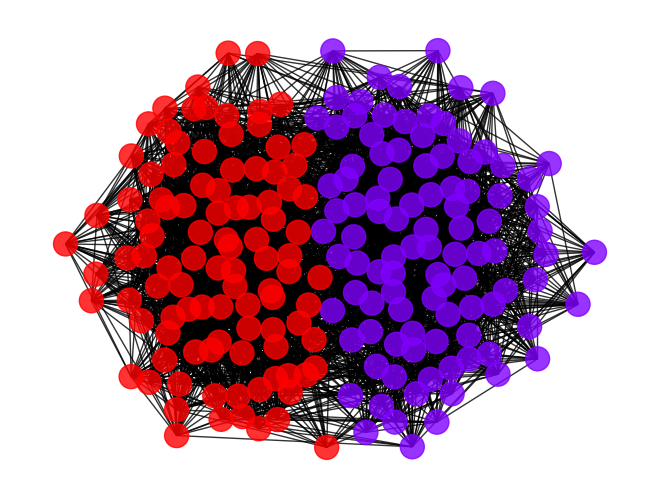

In [ ]:
draw_graph(weighted_data[(0.5,0.7)][5])

Graph, first 5 edges: 
Ricci curvature of edge (0,9) is 0.165542
Ricci curvature of edge (0,14) is 0.165556
Ricci curvature of edge (0,21) is 0.165529
Ricci curvature of edge (0,28) is 0.165549
Ricci curvature of edge (0,30) is 0.165555


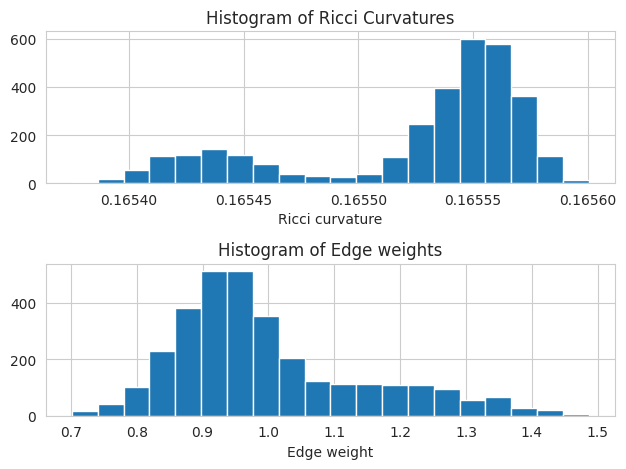

In [ ]:
show_results(weighted_data[(0.5,0.7)][5])

In [ ]:
!pip install pandas openpyxl

file_path = 'weighted_data.xlsx'

# Use the to_excel method to export the DataFrame
weighted_summary.to_excel(file_path, engine='openpyxl')


In [ ]:
remove_prob_matrix = [
      [0,0],
      [0,0]]
model = block_model_with_edge_removal([100,100],
                                      prob_matrix=prob_matrix,
                                      p = remove_prob_matrix,
                                      method = "weighted")
edges_between_communities(model)

array([[2490, 1253],
       [1253, 2465]])

In [ ]:

num_cut, n, num_edges, mod, ari, G = weighted_ricci_simulation(model, iterations = 20, exp = 2, cut = 1.5)



INFO:GraphRicciCurvature:Edge weight not detected in graph, use "weight" as default edge weight.
INFO:GraphRicciCurvature:No ricciCurvature detected, compute original_RC...
INFO:GraphRicciCurvature:4.299003 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 0 === 
INFO:GraphRicciCurvature:5.631259 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 1 === 
INFO:GraphRicciCurvature:6.033201 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 2 === 
INFO:GraphRicciCurvature:9.163543 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 3 === 
INFO:GraphRicciCurvature:5.628288 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 4 === 
INFO:GraphRicciCurvature:6.803688 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 5 === 
INFO:GraphRicciCurvature:5.510722 secs for Ricc

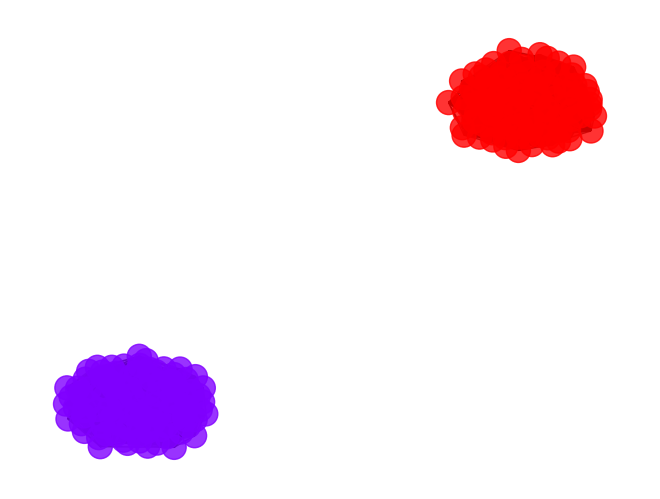

In [ ]:
draw_graph(G)

Graph, first 5 edges: 
Ricci curvature of edge (0,5) is 0.200632
Ricci curvature of edge (0,6) is 0.199158
Ricci curvature of edge (0,7) is 0.196104
Ricci curvature of edge (0,8) is 0.191408
Ricci curvature of edge (0,12) is 0.192986


1.0

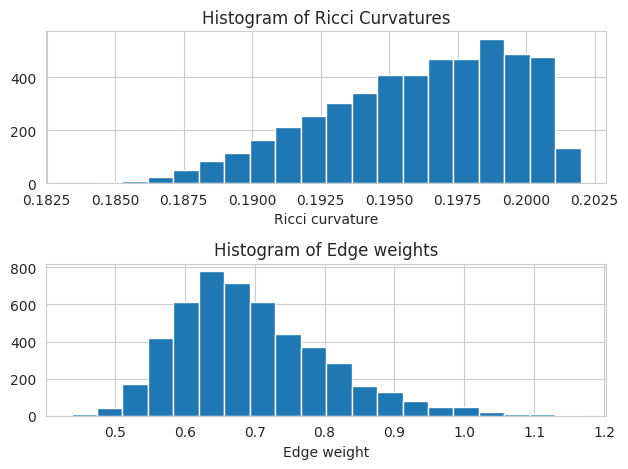

In [ ]:
show_results(G)
ARI(G,list(nx.connected_components(G)))

In [ ]:
remove_prob_matrix = [
      [0.5,0.7],
      [0.7,0.5]]
p_inter, p_intra = 0.1, 0.5
prob_matrix = [
    [p_intra, p_inter],
    [p_inter, p_intra]
]
model = block_model_with_edge_removal([100,100],
                                      prob_matrix=prob_matrix,
                                      p = 0.5,
                                      method = "degree")
num_cut, n, num_edges, mod, ari, G = ricci_simulation(model, iterations = 10, exp = 1, alpha = 0)
print(num_cut, n, num_edges, mod, ari)

INFO:GraphRicciCurvature:Edge weight not detected in graph, use "weight" as default edge weight.
INFO:GraphRicciCurvature:No ricciCurvature detected, compute original_RC...
INFO:GraphRicciCurvature:1.502698 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 0 === 
INFO:GraphRicciCurvature:1.868025 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 1 === 
INFO:GraphRicciCurvature:1.803701 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 2 === 
INFO:GraphRicciCurvature:3.454908 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 3 === 
INFO:GraphRicciCurvature:1.408838 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 4 === 
INFO:GraphRicciCurvature:1.497696 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 5 === 
INFO:GraphRicciCurvature:1.056417 secs for Ricc

21 200 1520 4.440892098500626e-16 0.0


Graph, first 5 edges: 
Ricci curvature of edge (0,9) is -0.177662
Ricci curvature of edge (0,16) is -0.177626
Ricci curvature of edge (0,25) is -0.177661
Ricci curvature of edge (0,29) is -0.177670
Ricci curvature of edge (0,32) is -0.177676


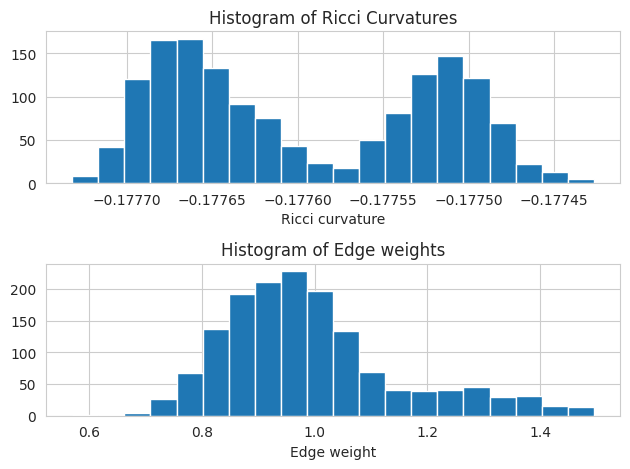

In [ ]:
show_results(G)

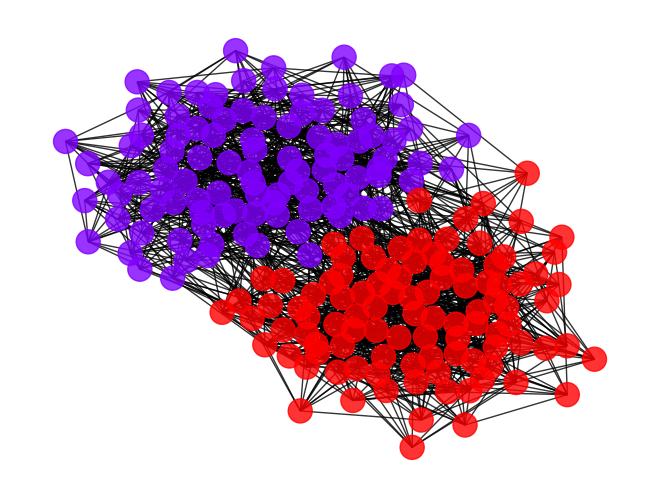

In [ ]:
draw_graph(G)

# Data Setup

In [ ]:
column_names = ["Type of Model", "p_intra", "p_inter","remove_intra", "remove_inter",
                "Method for Missingness", "ARI", "Modularity", "Number Components in Best Partition", "Cutoff"]
data = pd.DataFrame(columns=column_names)

# Spectral Method Analysis Degree and Uniform Missingness

In [ ]:
block_sizes = [100, 100]
p_inter, p_intra = 0.25, 0.5
prob_matrix = [
    [p_intra, p_inter],
    [p_inter, p_intra]
]

for typ in ["uniform", "degree"]:
  for prob in [0.3, 0.5,0.7, 0.8,0.85,0.9, 0.93, 0.95, 0.97]:
    G = block_model_with_edge_removal(block_sizes,
                                          prob_matrix=prob_matrix,
                                          p = prob,
                                          method = typ)
    spectral_model, s_ari = spectral_analysis(G)
    new_row_spectral = {
    "Type of Model": "Spectral",
    "p_intra": p_intra,
    "p_inter": p_inter,
    "remove_intra": prob,
    "remove_inter": prob,
    "Method for Missingness": typ,
    "ARI": s_ari,
    "Modularity": "NA",
    "Cutoff": 0,
    "Number Components in Best Partition": -1
    }
    data = pd.concat([data, pd.DataFrame([new_row_spectral])], ignore_index=True)

    num_components, ricci_model, r_ari, r_mod, cut_off = ricci_simulation(G)
    new_row_ricci = {
    "Type of Model": "Ricci",
    "p_intra": p_intra,
    "p_inter": p_inter,
    "remove_intra": prob,
    "remove_inter": prob,
    "Method for Missingness": typ,
    "ARI": r_ari,
    "Modularity": r_mod,
    "Cutoff": cut_off,
    "Number Components in Best Partition": num_components
    }
    data = pd.concat([data, pd.DataFrame([new_row_ricci])], ignore_index=True)
data


,Type of Model,p_intra,p_inter,remove_intra,remove_inter,Method for Missingness,ARI,Modularity,Number Components in Best Partition,Cutoff
0,Spectral,0.5,0.25,0.30,0.30,uniform,1.000000,NA,-1,0
1,Ricci,0.5,0.25,0.30,0.30,uniform,0.000000,-0.0,1,1.294655
2,Spectral,0.5,0.25,0.50,0.50,uniform,0.960200,NA,-1,0
3,Ricci,0.5,0.25,0.50,0.50,uniform,0.000000,0.0,1,1.246602
4,Spectral,0.5,0.25,0.70,0.70,uniform,0.687348,NA,-1,0
5,Ricci,0.5,0.25,0.70,0.70,uniform,-0.000100,-0.0,3,1.028048
6,Spectral,0.5,0.25,0.80,0.80,uniform,0.356779,NA,-1,0
7,Ricci,0.5,0.25,0.80,0.80,uniform,0.000003,0.0,5,1.015874
8,Spectral,0.5,0.25,0.85,0.85,uniform,0.226538,NA,-1,0
9,Ricci,0.5,0.25,0.85,0.85,uniform,-0.000100,-0.0,3,1.056108


In [ ]:
block_sizes = [100, 100]
p_inter, p_intra = 0.125, 0.5
prob_matrix = [
    [p_intra, p_inter],
    [p_inter, p_intra]
]

for typ in ["uniform", "degree"]:
  for prob in [0.3, 0.5,0.7, 0.8,0.85,0.9, 0.93, 0.95, 0.97]:
    G = block_model_with_edge_removal(block_sizes,
                                          prob_matrix=prob_matrix,
                                          p = prob,
                                          method = typ)
    spectral_model, s_ari = spectral_analysis(G)
    new_row_spectral = {
    "Type of Model": "Spectral",
    "p_intra": p_intra,
    "p_inter": p_inter,
    "remove_intra": prob,
    "remove_inter": prob,
    "Method for Missingness": typ,
    "ARI": s_ari,
    "Modularity": "NA",
    "Cutoff": 0,
    "Number Components in Best Partition": -1
    }
    data = pd.concat([data, pd.DataFrame([new_row_spectral])], ignore_index=True)

    num_components, ricci_model, r_ari, r_mod, cut_off = ricci_simulation(G)
    new_row_ricci = {
    "Type of Model": "Ricci",
    "p_intra": p_intra,
    "p_inter": p_inter,
    "remove_intra": prob,
    "remove_inter": prob,
    "Method for Missingness": typ,
    "ARI": r_ari,
    "Modularity": r_mod,
    "Cutoff": cut_off,
    "Number Components in Best Partition": num_components
    }
    data = pd.concat([data, pd.DataFrame([new_row_ricci])], ignore_index=True)
data


,Type of Model,p_intra,p_inter,remove_intra,remove_inter,Method for Missingness,ARI,Modularity,Number Components in Best Partition,Cutoff
0,Spectral,0.5,0.250,0.30,0.30,uniform,1.000000,NA,-1,0
1,Ricci,0.5,0.250,0.30,0.30,uniform,0.000000,-0.0,1,1.294655
2,Spectral,0.5,0.250,0.50,0.50,uniform,0.960200,NA,-1,0
3,Ricci,0.5,0.250,0.50,0.50,uniform,0.000000,0.0,1,1.246602
4,Spectral,0.5,0.250,0.70,0.70,uniform,0.687348,NA,-1,0
...,...,...,...,...,...,...,...,...,...,...
67,Ricci,0.5,0.125,0.93,0.93,degree,0.000000,0.0,1,1.0
68,Spectral,0.5,0.125,0.95,0.95,degree,0.000201,NA,-1,0
69,Ricci,0.5,0.125,0.95,0.95,degree,0.000000,0.0,1,1.0
70,Spectral,0.5,0.125,0.97,0.97,degree,-0.000772,NA,-1,0


# Spectral Method Analysis Weighted Missingness

In [ ]:
block_sizes = [100, 100]
p_inter, p_intra = 0.25, 0.5
prob_matrix = [
    [p_intra, p_inter],
    [p_inter, p_intra]
]

for i in [0.5, 0.7, 0.8, 0.85, 0.9, 0.95]:
  for j in [0.5, 0.7, 0.8, 0.85, 0.9, 0.95]:
      remove_prob_matrix = [
      [i, j],
      [j, i]]
      G = block_model_with_edge_removal(block_sizes,
                                            prob_matrix=prob_matrix,
                                            p = remove_prob_matrix,
                                            method = "weighted")
      spectral_model, s_ari = spectral_analysis(G)
      new_row_spectral = {
      "Type of Model": "Spectral",
      "p_intra": p_intra,
      "p_inter": p_inter,
      "remove_intra": i,
      "remove_inter": j,
      "Method for Missingness": "Weighted",
      "ARI": s_ari,
      "Modularity": "NA",
      "Cutoff": 0,
      "Number Components in Best Partition": -1
      }
      data = pd.concat([data, pd.DataFrame([new_row_spectral])], ignore_index=True)

      num_components, ricci_model, r_ari, r_mod, cut_off = ricci_simulation(G)
      new_row_ricci = {
      "Type of Model": "Ricci",
      "p_intra": p_intra,
      "p_inter": p_inter,
      "remove_intra": i,
      "remove_inter": j,
      "Method for Missingness": "Weighted",
      "ARI": r_ari,
      "Modularity": r_mod,
      "Cutoff": cut_off,
      "Number Components in Best Partition": num_components
      }
      data = pd.concat([data, pd.DataFrame([new_row_ricci])], ignore_index=True)
data

,Type of Model,p_intra,p_inter,remove_intra,remove_inter,Method for Missingness,ARI,Modularity,Number Components in Best Partition,Cutoff
0,Spectral,0.5,0.25,0.30,0.30,uniform,1.000000,NA,-1,0
1,Ricci,0.5,0.25,0.30,0.30,uniform,0.000000,-0.0,1,1.294655
2,Spectral,0.5,0.25,0.50,0.50,uniform,0.960200,NA,-1,0
3,Ricci,0.5,0.25,0.50,0.50,uniform,0.000000,0.0,1,1.246602
4,Spectral,0.5,0.25,0.70,0.70,uniform,0.687348,NA,-1,0
...,...,...,...,...,...,...,...,...,...,...
140,Ricci,0.5,0.25,0.95,0.85,Weighted,0.000000,-0.0,2,1.141102
141,Spectral,0.5,0.25,0.95,0.90,Weighted,-0.001875,NA,-1,0
142,Ricci,0.5,0.25,0.95,0.90,Weighted,-0.000099,0.004146,3,1.115215
143,Spectral,0.5,0.25,0.95,0.95,Weighted,-0.000394,NA,-1,0


In [ ]:
block_sizes = [100, 100]
p_inter, p_intra = 0.125, 0.5
prob_matrix = [
    [p_intra, p_inter],
    [p_inter, p_intra]
]

for i in [0.5, 0.7, 0.8, 0.85, 0.9, 0.95]:
  for j in [0.5, 0.7, 0.8, 0.85, 0.9, 0.95]:
      remove_prob_matrix = [
      [i, j],
      [j, i]]
      G = block_model_with_edge_removal(block_sizes,
                                            prob_matrix=prob_matrix,
                                            p = remove_prob_matrix,
                                            method = "weighted")
      spectral_model, s_ari = spectral_analysis(G)
      new_row_spectral = {
      "Type of Model": "Spectral",
      "p_intra": p_intra,
      "p_inter": p_inter,
      "remove_intra": i,
      "remove_inter": j,
      "Method for Missingness": "Weighted",
      "ARI": s_ari,
      "Modularity": "NA",
      "Cutoff": 0,
      "Number Components in Best Partition": -1
      }
      data = pd.concat([data, pd.DataFrame([new_row_spectral])], ignore_index=True)

      num_components, ricci_model, r_ari, r_mod , cut_off= ricci_simulation(G)
      new_row_ricci = {
      "Type of Model": "Ricci",
      "p_intra": p_intra,
      "p_inter": p_inter,
      "remove_intra": i,
      "remove_inter": j,
      "Method for Missingness": "Weighted",
      "ARI": r_ari,
      "Modularity": r_mod,
      "Cutoff": cut_off,
      "Number Components in Best Partition": num_components
      }
      data = pd.concat([data, pd.DataFrame([new_row_ricci])], ignore_index=True)
data

,Type of Model,p_intra,p_inter,remove_intra,remove_inter,Method for Missingness,ARI,Modularity,Number Components in Best Partition,Cutoff
0,Spectral,0.5,0.250,0.30,0.30,uniform,1.000000,NA,-1,0
1,Ricci,0.5,0.250,0.30,0.30,uniform,0.000000,-0.0,1,1.294655
2,Spectral,0.5,0.250,0.50,0.50,uniform,0.960200,NA,-1,0
3,Ricci,0.5,0.250,0.50,0.50,uniform,0.000000,0.0,1,1.246602
4,Spectral,0.5,0.250,0.70,0.70,uniform,0.687348,NA,-1,0
...,...,...,...,...,...,...,...,...,...,...
212,Ricci,0.5,0.125,0.95,0.85,Weighted,-0.000219,-0.0,2,1.32045
213,Spectral,0.5,0.125,0.95,0.90,Weighted,0.000006,NA,-1,0
214,Ricci,0.5,0.125,0.95,0.90,Weighted,0.000515,0.0,3,1.322602
215,Spectral,0.5,0.125,0.95,0.95,Weighted,0.009632,NA,-1,0


# Export Data

In [ ]:
pip install openpyxl


In [ ]:
import pandas as pd


# Specify the filename
filename = 'data.xlsx'

# Export the DataFrame to Excel
data.to_excel(filename, index=False, engine='openpyxl')




In [30]:

from cdlib import algorithms, evaluation
from sklearn.metrics import adjusted_rand_score
import networkx as nx
from GraphRicciCurvature.OllivierRicci import OllivierRicci
# Implementing a function that computes the Ricci's Curvature and modularity of 
# a network that takes into account 2 hop neighbors when explaining missingness
def add_2_hop_neighbors_as_edges(G):
    """
    Modify the graph to include 2-hop neighbors as edges.
    This function assumes 'G' is a NetworkX graph.
    """
    G_modified = G.copy()
    for node in G.nodes():
        two_hop_neighbors = set(nx.single_source_shortest_path_length(G, node, cutoff=2).keys()) - {node}
        current_neighbors = set(nx.neighbors(G, node))
        for neighbor in two_hop_neighbors - current_neighbors:
            # Add an edge with a default weight or a custom weight based on your criteria
            G_modified.add_edge(node, neighbor, weight=0.4)  # Customize this weight as necessary
    return G_modified

def compute_modularity(G, partition):
    """
    Compute the modularity of a given partition using NetworkX.
    - G: NetworkX graph
    - partition: a list of sets, where each set represents a community.
    """
    # Prepare the partition in the format expected by NetworkX: a list of lists of nodes
    communities = [list(community) for community in partition]
    modularity = nx.algorithms.community.modularity(G, communities)
    return modularity

def compute_ricci_curvature_with_2_hop_neighbors_and_metrics(G, original_partition):
    """
    Compute Ricci curvature considering 2-hop neighbors and calculate modularity, ARI, and NRI.
    """
    # Ensure all edges have weights
    for u, v in G.edges():
        if 'weight' not in G[u][v]:
            G[u][v]['weight'] = 1.0  # Default weight

    # Add 2-hop neighbors as edges (pseudo-code, implement based on your needs)
    G_modified = add_2_hop_neighbors_as_edges(G)
    
    # Compute Ricci curvature on the modified graph
    orc = OllivierRicci(G_modified, alpha=0.5)
    orc.compute_ricci_curvature()
    
    # Detect communities in the modified graph
    communities = algorithms.louvain(orc.G)
    partition = [set(com) for com in communities.communities]
    
    # Compute metrics
    modularity = compute_modularity(orc.G, partition)
    
    return orc.G, modularity

# Helper function to convert community detection result into a partition format for modularity calculation
def community_to_partition(G, community_detection_func):
    communities = community_detection_func(G)
    return [set(com) for com in communities.communities]

In [18]:
pip install GraphRicciCurvature


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [31]:
from cdlib import algorithms, evaluation
from sklearn.metrics import adjusted_rand_score
import networkx as nx
from GraphRicciCurvature.OllivierRicci import OllivierRicci


def generate_sbm_graph(sizes, p_matrix):
    """
    Generate a Stochastic Block Model graph.
    
    :param sizes: List of sizes of the blocks.
    :param p_matrix: Matrix of probabilities. p_matrix[i][j] is the probability of an edge
                     between a node in block i and a node in block j.
    :return: A generated SBM graph.
    """
    return nx.stochastic_block_model(sizes, p_matrix)

# Example usage to generate an SBM graph
sizes = [50, 50]  # Two communities, each with 50 nodes
p_intra = 0.1  # Probability of edges within the same community
p_inter = 0.01  # Probability of edges between communities
p_matrix = [[p_intra, p_inter], [p_inter, p_intra]]  # Community connectivity matrix

# Generate the SBM graph
G_sbm = generate_sbm_graph(sizes, p_matrix)
for u, v in G_sbm.edges():
    if 'weight' not in G_sbm[u][v]:
        G_sbm[u][v]['weight'] = 1.0

# Assuming you have defined functions for computing Ricci curvature, modularity, ARI, and NRI
# you can now proceed with those computations using 'G_sbm'.

# For demonstration, let's detect communities in 'G_sbm' using the Louvain method:
communities = algorithms.louvain(G_sbm)
original_partition = [set(com) for com in communities.communities]

# Compute metrics such as modularity
modularity = evaluation.newman_girvan_modularity(G_sbm, communities)

print(f"Modularity of the detected communities: {modularity.score}")

# Assuming you have a function to compute Ricci curvature and other metrics, use 'G_sbm' as input.
G_with_metrics, modularity = compute_ricci_curvature_with_2_hop_neighbors_and_metrics(G_sbm, original_partition)

Modularity of the detected communities: 0.41862174232573907


In [35]:
print("Original Graph:")
print(f"Number of nodes: {G_sbm.number_of_nodes()}")
print(f"Number of edges: {G_sbm.number_of_edges()}")

print("\nModified Graph (with 2-hop neighbors):")
print(f"Number of nodes: {add_2_hop_neighbors_as_edges(G_sbm).number_of_nodes()}")
print(f"Number of edges: {add_2_hop_neighbors_as_edges(G_sbm).number_of_edges()}")

Original Graph:
Number of nodes: 100
Number of edges: 266

Modified Graph (with 2-hop neighbors):
Number of nodes: 100
Number of edges: 1414
